# Setup

In [ ]:
!pip install diffusers==0.18.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.2 MB/s eta 0:00:00


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Training Configuration

In [ ]:
from dataclasses import dataclass


@dataclass
class TrainingConfig:
    sequence_length = 256  # the generated image resolution
    train_data_paths = ['/content/p8_111.csv']
    filter_class = 1 # open, close, relax
    channel_shuffle = True
    emgs_cnt = 8 # must be 8 for 2D UNet
    train_batch_size = 16
    eval_batch_size = 16  # how many images to sample during evaluation
    num_epochs = 200
    save_epochs = 50
    learning_rate = 4e-4

    noise_scheduler_timesteps = 500

    # these three should be deleted
    noise_type = "normal" # normal
    noise_mean = 0
    noise_std = 1 # if using huggingface pipeline, set it to 1

    gen_batch_size = 9 # gen_batch_size = nrows * ncols
    nrows = 3
    ncols = 3

    model_type = "2DUNet"

    load_model = False
    load_model_path = "./2Dunet-p8-111-ep400"
    train = True
    save_model = False
    save_model_path = "./2Dunet-p8-111-ep200"


config = TrainingConfig()

# Visualization Helper functions

In [ ]:
import matplotlib.pyplot as plt

def visualize_one_emg(data, emg_idx):
  plt.plot(data)
  plt.xlabel('Time')
  plt.ylabel('emg '+str(emg_idx)+' normalized value')
  plt.show()
  plt.close()

def visualize_sample(sample, emgs_cnt, unsqueeze=True):
  if unsqueeze:
    sample = sample.unsqueeze(0)
  print(sample.shape)
  for i in range(emgs_cnt):
    visualize_one_emg(sample[0][i], i)
    pass

From misc_utils

In [ ]:
def plot_emg_chunks(data, nrows=1, ncols=1, vertical_location=None):
    """
    data: (b, t, 8), b = nrows * ncols
    """
    # missing the batch dimension
    if np.ndim(data) == 2:
        data = data[None, ...]
    b, t = data.shape[:2]
    fig, axs = plt.subplots(figsize=(15, 9), nrows=nrows, ncols=ncols, squeeze=False)

    idx = np.array(range(t)) / 100.0
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'tab:brown']

    for i in range(nrows):
        for j in range(ncols):
            for c in range(8):
                y = data[i*ncols+j, :, c]
                axs[i, j].plot(idx, y, label=f'emg{c}', alpha=0.7, color=colors[c])
                if vertical_location is not None:
                    axs[i, j].axvline(x=vertical_location / 100.0, c='b')
                if i*ncols+j == b - 1:
                    axs[i, j].legend()

    plt.xlabel('time (seconds)')
    plt.tight_layout()

    plt.show()

#ChatEMG Dataset

Statistics of p1_111:<br>
Mean of each emg: <br>[0.0451946  0.14492683 0.19912494 0.08450989 0.08813588 0.05372675
 0.04034895 0.07792921] <br>
Std of each emg: <br>
[0.02988127 0.06865422 0.11946873 0.07062819 0.07399311 0.08520439
 0.02091565 0.04998798]

From misc_utils.py

In [ ]:
# copied from misc_utils.py from emg_predictors
def keep_columns(df, tuple_of_columns):
    """
    Given a dataframe, and a tuple of column names, this function will search
    through the dataframe and keep only columns which contain a string from the
    list of the desired columns. All other columns are removed
    """
    if len(tuple_of_columns) >= 1:
        cols = df.columns[df.columns.to_series().str.contains('|'.join(tuple_of_columns))]
        return df[cols]
    return df

def clean_dataframe(df):
    X_df = keep_columns(df, [f'emg'])
    X = X_df.to_numpy()
    y_df = keep_columns(df, ['gt'])
    y = y_df.to_numpy().squeeze()
    return X, y

From ChatEMG Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
import os
import pathlib
#import misc_utils as mu
import pandas as pd
import numpy as np


class ChatEMGDataset(Dataset):
    def __init__(self, csv_files, filter_class, block_size, normalize=False):
        self.csv_files = csv_files
        self.filter_class = filter_class
        self.block_size = block_size

        #self.data_files_base_directory = \os.path.join(pathlib.Path(__file__).resolve().parent.parent.__str__(), 'collected_data')

        data_list = []
        label_list = []
        for f in self.csv_files:
            #data_path = os.path.join(self.data_files_base_directory, f)
            data_path = f
            df = pd.read_csv(data_path, index_col=0)
            #X, y = mu.clean_dataframe(df)
            X, y = clean_dataframe(df)
            X = np.clip(X, a_min=0, a_max=999)
            X = X / 999 if normalize else X
            data_list.append(X)
            label_list.append(y)

        self.filtered_data_list = data_list
        if self.filter_class is not None:
            self.filtered_data_list = []
            for d, l in zip(data_list, label_list):
                filtered_d = []
                for i in range(len(d)):
                    if l[i] == self.filter_class:
                        filtered_d.append(d[i])
                        if i+1 == len(d) or l[i+1] != self.filter_class:
                            self.filtered_data_list.append(np.array(filtered_d))
                            filtered_d = []

        # now I am removing chunks shorter than block size + 1, because we need to consider y as well
        self.filtered_data_list = [d for d in self.filtered_data_list if len(d) >= (self.block_size + 1)]
        # number of (x, y) pairs in each chunk
        self.filtered_data_lens = [len(d) - self.block_size for d in self.filtered_data_list]

    def __len__(self):
        return sum(self.filtered_data_lens)

    def __getitem__(self, item):
        assert item < self.__len__()

        s = 0
        for i, l in enumerate(self.filtered_data_lens):
            s_new = s + l
            if s <= item < s_new:
                x = self.filtered_data_list[i][item - s: item - s + self.block_size]
                # print(item - s, item - s + self.block_size)
                y = self.filtered_data_list[i][item - s + 1: item - s + self.block_size + 1]
                # print(item - s + 1, item - s + self.block_size + 1)
                # print(i)
                return x, y
            s = s_new

    def sample(self, num):
        # sample some samples without replacement
        idx = np.random.choice(range(self.__len__()), num, replace=False)
        X = []
        Y = []
        for i in idx:
            x, y = self.__getitem__(i)
            X.append(x)
            Y.append(y)
        return np.stack(X), np.stack(Y)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import os
import pathlib
#import misc_utils as mu
import pandas as pd
import numpy as np


class ChatEMGDataset(Dataset):
    def __init__(self, csv_files, filter_class, block_size, normalize=False, standardize=False, shuffle_channel=False):
        assert not (normalize and standardize)  # cannot standardize and normalize at the same time
        self.csv_files = csv_files
        self.filter_class = filter_class
        self.block_size = block_size
        self.shuffle_channel = shuffle_channel
        self.normalize = normalize
        self.standardize = standardize

        #self.data_files_base_directory = \os.path.join(pathlib.Path(__file__).resolve().parent.parent.__str__(), 'collected_data')

        data_list = []
        label_list = []
        for f in self.csv_files:
            #data_path = os.path.join(self.data_files_base_directory, f)
            data_path = f
            df = pd.read_csv(data_path, index_col=0)
            #X, y = mu.clean_dataframe(df)
            X, y = clean_dataframe(df)
            if normalize:
                X = np.clip(X, a_min=0, a_max=999)
                X = X / 999
            data_list.append(X)
            label_list.append(y)

        self.filtered_data_list = data_list
        if self.filter_class is not None:
            self.filtered_data_list = []
            for d, l in zip(data_list, label_list):
                filtered_d = []
                for i in range(len(d)):
                    if l[i] == self.filter_class:
                        filtered_d.append(d[i])
                        if i+1 == len(d) or l[i+1] != self.filter_class:
                            self.filtered_data_list.append(np.array(filtered_d))
                            filtered_d = []

        # now I am removing chunks shorter than block size + 1, because we need to consider y as well
        self.filtered_data_list = [d for d in self.filtered_data_list if len(d) >= (self.block_size + 1)]
        # compute mean and std
        self.mean = np.mean(np.concatenate(self.filtered_data_list), axis=0)
        self.std = np.std(np.concatenate(self.filtered_data_list), axis=0)
        if self.standardize:
            self.filtered_data_list = [(d - self.mean) / self.std for d in self.filtered_data_list]
        # number of (x, y) pairs in each chunk
        self.filtered_data_lens = [len(d) - self.block_size for d in self.filtered_data_list]

    def overwrite_mean_std(self, mean, std):
        assert self.standardize
        # revert the standardization process
        self.filtered_data_list = [d * self.std + self.mean for d in self.filtered_data_list]
        self.mean = mean
        self.std = std
        # standardization using the new mean and std
        self.filtered_data_list = [(d - self.mean) / self.std for d in self.filtered_data_list]

    def __len__(self):
        return sum(self.filtered_data_lens)

    def __getitem__(self, item):
        assert item < self.__len__()

        s = 0
        for i, l in enumerate(self.filtered_data_lens):
            s_new = s + l
            if s <= item < s_new:
                x = self.filtered_data_list[i][item - s: item - s + self.block_size]
                # print(item - s, item - s + self.block_size)
                y = self.filtered_data_list[i][item - s + 1: item - s + self.block_size + 1]
                # print(item - s + 1, item - s + self.block_size + 1)
                # print(i)
                if self.shuffle_channel:
                    permutation = np.random.permutation(8)
                    x = x[:, permutation]
                    y = y[:, permutation]
                return x, y
            s = s_new

    def sample(self, num):
        # sample some samples without replacement
        idx = np.random.choice(range(self.__len__()), num, replace=False)
        X = []
        Y = []
        for i in idx:
            x, y = self.__getitem__(i)
            X.append(x)
            Y.append(y)
        return np.stack(X), np.stack(Y)

In [ ]:
dataset = ChatEMGDataset(
    csv_files = config.train_data_paths,
    filter_class = config.filter_class,
    block_size = config.sequence_length,
    normalize = True,
    shuffle_channel = config.channel_shuffle
)
print("sum samples: ", len(dataset))

sum samples:  952


Support function: get_sample, will convert to our shape

In [ ]:
def get_sample(cnt):
  raw_sample = dataset.sample(cnt)
  # convert to np array
  np_sample = np.array(raw_sample) # (2, cnt, block_size, emg_cnt)
  # take only the X component
  x_sample = np_sample[0] # (cnt, block_size, emg_cnt)
  # permute the dimensions
  trans_sample = np.transpose(x_sample, axes=(0,2,1)) #(cnt, emg_cnt, block_size)
  # convert to torch
  sample_tensor = torch.tensor(trans_sample).to(torch.float32)
  return sample_tensor

In [ ]:
import torch

#train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=config.train_batch_size, shuffle=True)
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=config.train_batch_size, shuffle=True)

(9, 256, 8)


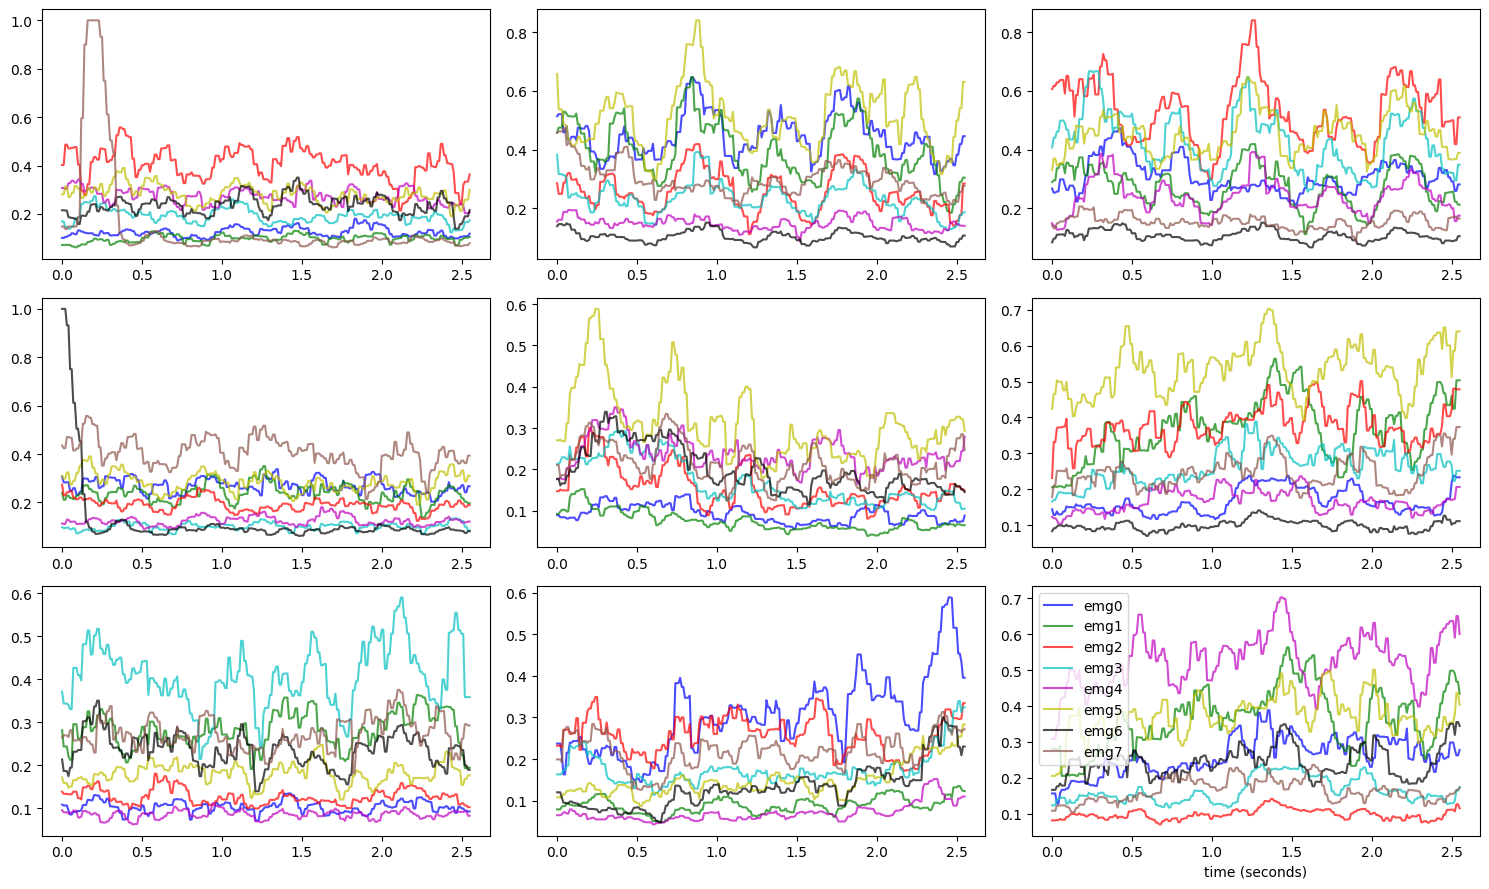

In [ ]:
sample_seqs = np.array(dataset.sample(9))
sample_seqs = sample_seqs[0]
print(sample_seqs.shape)
plot_emg_chunks(sample_seqs, nrows=3, ncols=3)

# Load an Existing UNet2D Model

In [ ]:
!unzip 2Dunet-p8-111-ep400.zip

Archive:  2Dunet-p8-111-ep400.zip
   creating: 2Dunet-p8-111-ep400/
  inflating: 2Dunet-p8-111-ep400/config.json  
  inflating: 2Dunet-p8-111-ep400/diffusion_pytorch_model.bin  


In [ ]:
from diffusers import UNet2DModel
if config.load_model and config.model_type=="2DUNet":
  model = UNet2DModel.from_pretrained(config.load_model_path).to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


# Create a UNet2DModel

In [ ]:
from diffusers import UNet2DModel

# Create a model
if not config.load_model:
  model = UNet2DModel(
      sample_size=(config.emgs_cnt,config.sequence_length),  # the target image resolution
      in_channels=1,  # the number of input channels, 3 for RGB images
      out_channels=1,  # the number of output channels
      layers_per_block=2,  # how many ResNet layers to use per UNet block
      block_out_channels=(64, 128, 128, 256),  # More channels -> more parameters
      down_block_types=(
          "DownBlock2D",  # a regular ResNet downsampling block
          "DownBlock2D",
          "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
          "AttnDownBlock2D",
      ),
      up_block_types=(
          "AttnUpBlock2D",
          "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
          "UpBlock2D",
          "UpBlock2D",  # a regular ResNet upsampling block
      ),
  )
  model.to(device);

use pretrained checkpoints

check the input shape and output shape

torch.Size([1, 8, 256])


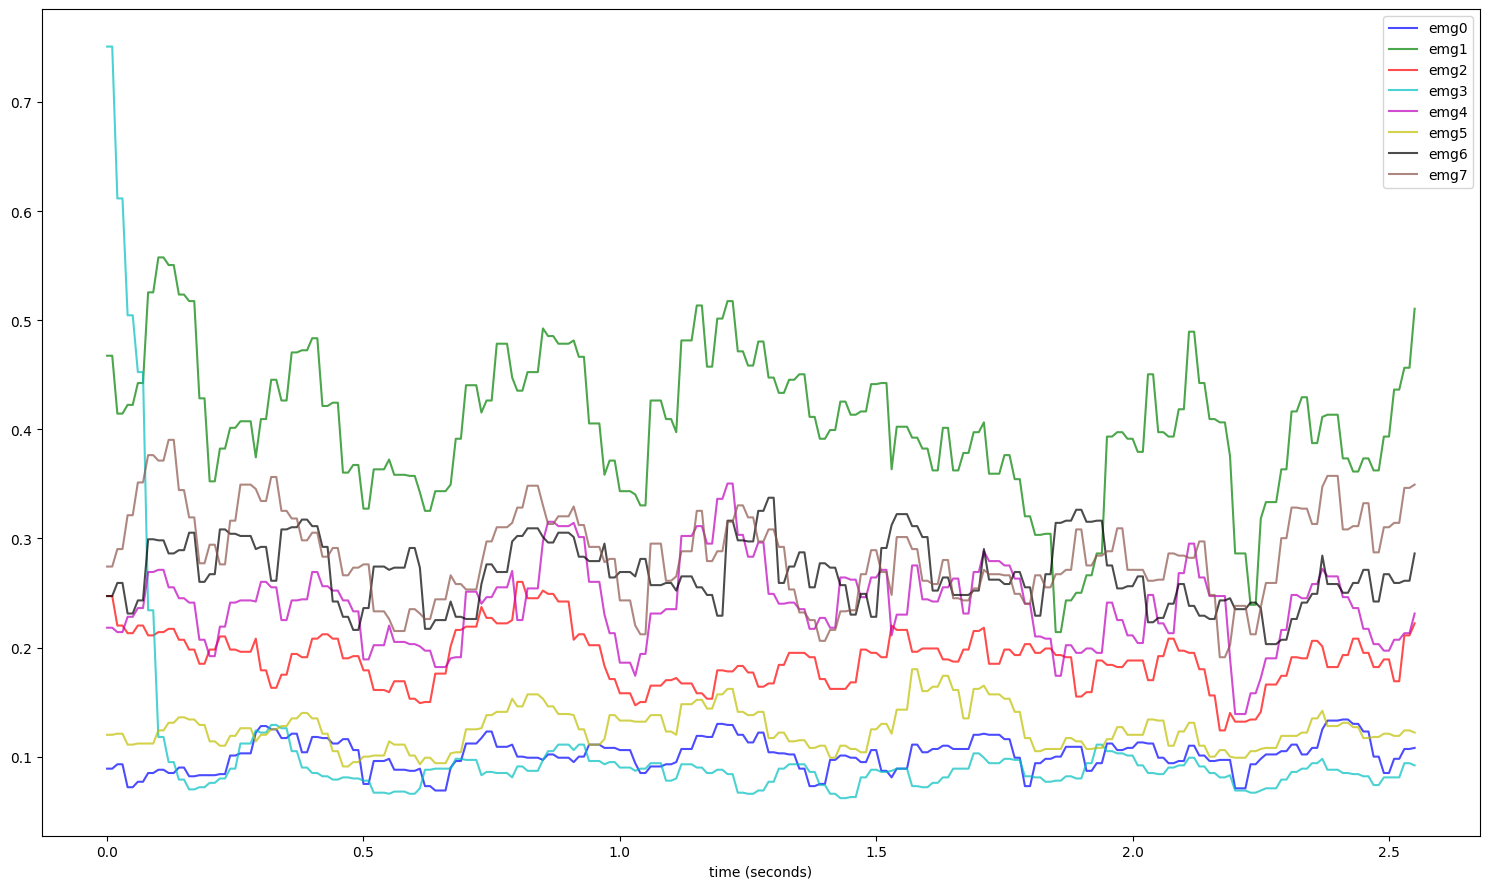

Input shape: torch.Size([1, 1, 8, 256])


In [ ]:
sample_seq = get_sample(1)
print(sample_seq.shape)
sample_for_plot = sample_seq.permute(0,2,1)
plot_emg_chunks(sample_for_plot)
sample_seq = sample_seq.to(device)

if config.model_type=="2DUNet":
  sample_seq = sample_seq.unsqueeze(1)
print("Input shape:", sample_seq.shape)

Expect format: (batch, channel, height, width).

In [ ]:
print("Output shape:", model(sample_seq, timestep=0).sample.shape)

Output shape: torch.Size([1, 1, 8, 256])


Check the number of parameters

In [ ]:
sum([p.numel() for p in model.parameters()])

18534017

# Create a Scheduler

Create a noise scheduler & plot its scheduling curve

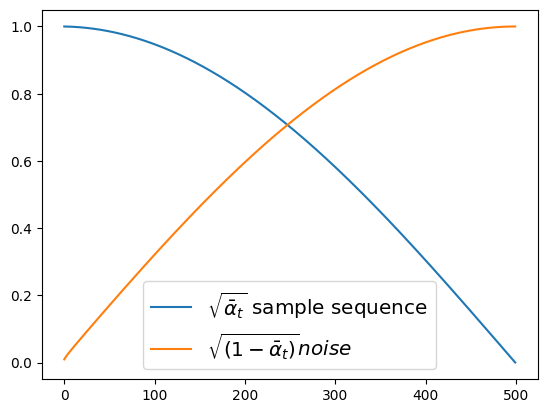

In [ ]:
from diffusers import DDPMScheduler

# Scheduler: can change parameters such as beta_start=0.001, beta_end=0.004, beta_schedule='squaredcos_cap_v2'
noise_scheduler = DDPMScheduler(num_train_timesteps=config.noise_scheduler_timesteps, beta_schedule='squaredcos_cap_v2')

# plot
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$ sample sequence")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)} noise$")
plt.legend(fontsize="x-large");

Testing add noise

Problem: each sequential segments has very diverse distribution: compare traindata[1000] with traindata[5300]</br>
for sample_idx == 1000, normal noise will corrupt too soon, uniform noise will be better </br>
for sample_idx == 5300, uniform noise not enough, normal noise good

In [ ]:
view_cnt = 1
noise_type = config.noise_type# normal: normal distribution; uniform: uniform distribution within {-1,1}

sample_seq = get_sample(1)
print("Original Sequence from sample: ")
print("mean: ", np.mean(sample_seq.numpy(), axis=2))
visualize_sample(sample_seq[0], view_cnt)

noise = torch.randn(sample_seq.shape) # original can i bound its range # reduce the range

# print("Noise added:")
# print("Noise max", np.max(noise.numpy()))
# print("Noise min", np.min(noise.numpy()))
# print("Noise shape", noise.numpy().shape)
# print("Noise mean", np.mean(noise.numpy(), axis=2))
# print("Noise std", np.std(noise.numpy(), axis=2))
print(noise.shape)
visualize_sample(noise[0], view_cnt)

for steps_added in [0, 100, 200, 300, 400, 499]:
  print("steps_added: ", steps_added)
  timesteps = torch.LongTensor([steps_added])
  noisy_seq = noise_scheduler.add_noise(sample_seq, noise, timesteps)
  print("mean: ", np.mean(noisy_seq.numpy(), axis=2))
  print("Sequence + Noise:")
  visualize_sample(noisy_seq[0], view_cnt)

# Create a Train Loop

from train.py

In [ ]:
def get_batch(split):
    if split == 'train':
        return next(iter(train_dataloader))
    elif split == 'val':
        return next(iter(test_dataloader))

my support function

In [ ]:
def diffuser_batch_preprocess(X, is2d=False):
  trans_X = np.transpose(X, axes=(0,2,1))
  tensor_X = torch.tensor(trans_X).to(torch.float32)
  if is2d:
    tensor_X = tensor_X.unsqueeze(1)
    # expected shape: (batch, channel, height, width),
    # here we are setting it to (batch, 1, height=8=emgChannels, width=sequence_length)
  return tensor_X

check generate seqs

In [ ]:
from diffusers import DDPMPipeline

def deterministic_generate_sequences(this_model):
  deterministic_generator = torch.Generator()
  deterministic_generator.manual_seed(42)
  emgseq_pipe = DDPMPipeline(unet=this_model, scheduler=noise_scheduler)
  pipeline_output = emgseq_pipe(batch_size=config.gen_batch_size,num_inference_steps=config.noise_scheduler_timesteps,output_type=np.array,generator=deterministic_generator)
  gen_seqs = pipeline_output.images
  gen_seqs = gen_seqs.squeeze()
  print("shape: ", gen_seqs.shape)
  gen_seqs = np.transpose(gen_seqs, axes=(0,2,1))
  print("mean: ", np.mean(gen_seqs, axis=2))
  print("std: ", np.std(gen_seqs, axis=2))
  plot_emg_chunks(gen_seqs, nrows=config.nrows, ncols=config.ncols)
  return pipeline_output.images

Total epochs:  200
Epoch:  0


<ipython-input-18-050d5c5ac8e0>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_X = torch.tensor(trans_X).to(torch.float32)


Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:5, loss: 0.038944488608588776
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Epoch:10, loss: 0.03485359509165088
Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Epoch:  14
Epoch:15, loss: 0.02461322769522667
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Epoch:  19
Epoch:20, loss: 0.025737797468900682
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Epoch:  24
Epoch:25, loss: 0.023537409227962294
Epoch:  25
Epoch:  26
Epoch:  27
Epoch:  28
Epoch:  29
Epoch:30, loss: 0.023864624191386005
Epoch:  30
Epoch:  31
Epoch:  32
Epoch:  33
Epoch:  34
Epoch:35, loss: 0.020368951822941503
Epoch:  35
Epoch:  36
Epoch:  37
Epoch:  38
Epoch:  39
Epoch:40, loss: 0.024773428806414206
Epoch:  40
Epoch:  41
Epoch:  42
Epoch:  43
Epoch:  44
Epoch:45, loss: 0.021914188641433914
Epoch:  45
Epoch:  46
Epoch:  47
Epoch:  48
Epoch:  49
Epoch:50, loss: 0.018866544643727442
Saving...


  0%|          | 0/500 [00:00<?, ?it/s]

shape:  (9, 8, 256)
mean:  [[0.69129884 0.67751694 0.6867984  ... 0.68630165 0.68409    0.68469185]
 [0.6223555  0.61960995 0.61985844 ... 0.621333   0.62767917 0.6242013 ]
 [0.38626435 0.4176534  0.42359394 ... 0.413974   0.40630317 0.3787914 ]
 ...
 [0.3776123  0.4046325  0.4045332  ... 0.3968111  0.4157173  0.3650055 ]
 [0.7671508  0.7579356  0.7593685  ... 0.7963233  0.78624845 0.7827468 ]
 [0.49414566 0.5092534  0.5007453  ... 0.5034764  0.5061833  0.4882999 ]]
std:  [[0.06127743 0.06260536 0.06707612 ... 0.06831794 0.0668195  0.06458454]
 [0.06766161 0.06424825 0.06038662 ... 0.04878377 0.048893   0.05511776]
 [0.04013056 0.03529074 0.02144664 ... 0.03797996 0.02875154 0.02901786]
 ...
 [0.02497125 0.0182291  0.02044363 ... 0.03150429 0.02589173 0.03749559]
 [0.07745331 0.07671046 0.07674155 ... 0.07034919 0.06570424 0.06518959]
 [0.02536444 0.01911136 0.02154933 ... 0.02704867 0.02995524 0.03438416]]


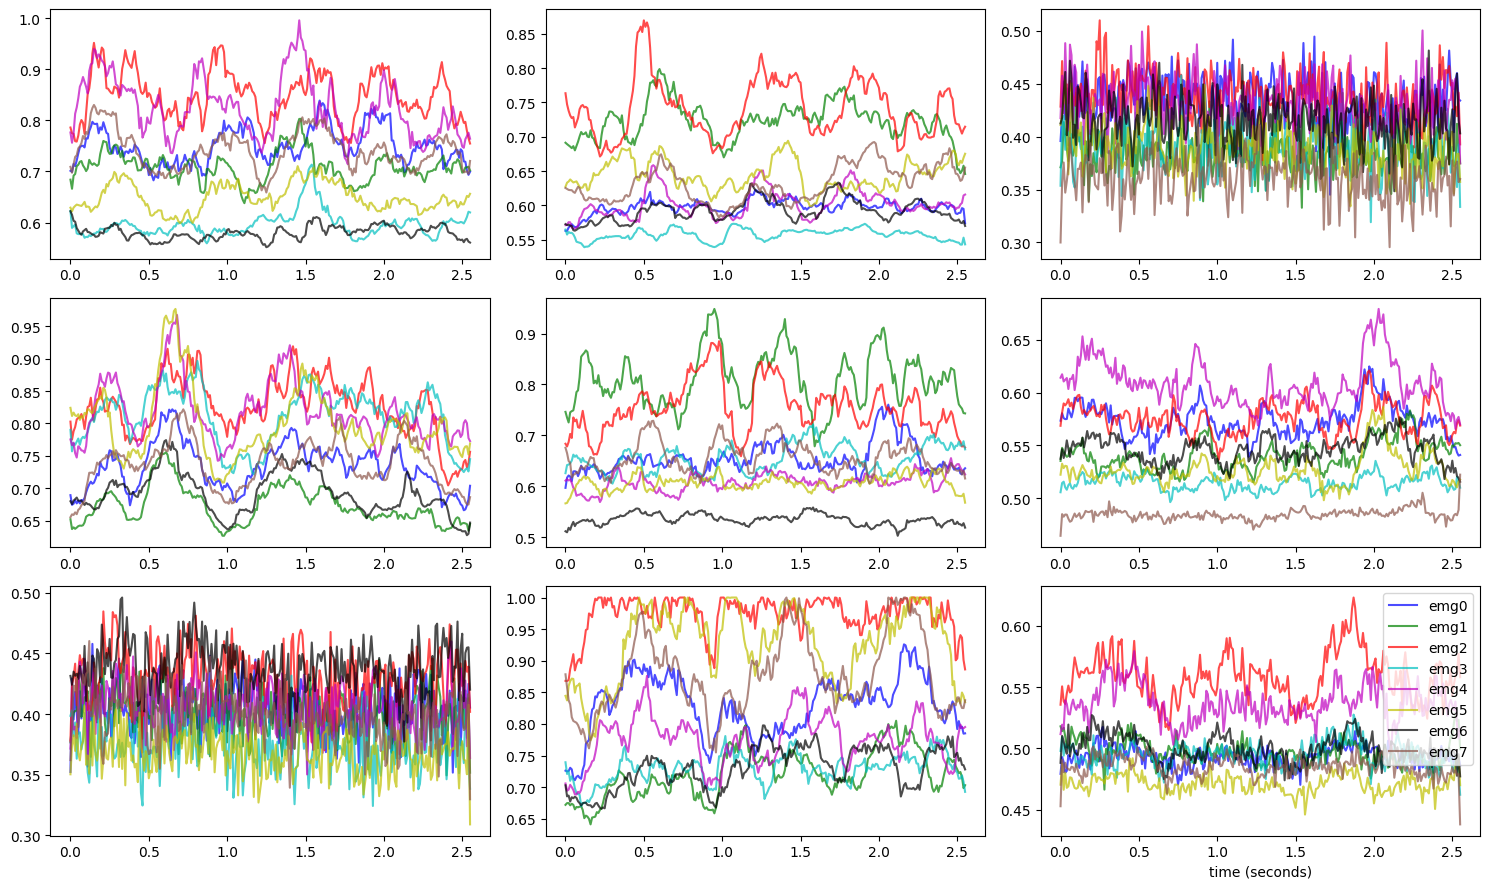

Epoch:  50
Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:55, loss: 0.02274485487335672
Epoch:  55
Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:60, loss: 0.021097966011924048
Epoch:  60
Epoch:  61
Epoch:  62
Epoch:  63
Epoch:  64
Epoch:65, loss: 0.019697864524399242
Epoch:  65
Epoch:  66
Epoch:  67
Epoch:  68
Epoch:  69
Epoch:70, loss: 0.0220773345635583
Epoch:  70
Epoch:  71
Epoch:  72
Epoch:  73
Epoch:  74
Epoch:75, loss: 0.01648666460532695
Epoch:  75
Epoch:  76
Epoch:  77
Epoch:  78
Epoch:  79
Epoch:80, loss: 0.023975195658082763
Epoch:  80
Epoch:  81
Epoch:  82
Epoch:  83
Epoch:  84
Epoch:85, loss: 0.015338556926387052
Epoch:  85
Epoch:  86
Epoch:  87
Epoch:  88
Epoch:  89
Epoch:90, loss: 0.01835076374312242
Epoch:  90
Epoch:  91
Epoch:  92
Epoch:  93
Epoch:  94
Epoch:95, loss: 0.01742839488045623
Epoch:  95
Epoch:  96
Epoch:  97
Epoch:  98
Epoch:  99
Epoch:100, loss: 0.019193673653838537
Saving...


  0%|          | 0/500 [00:00<?, ?it/s]

shape:  (9, 8, 256)
mean:  [[0.49996758 0.50359625 0.5055994  ... 0.49866062 0.49854016 0.48804283]
 [0.36090308 0.3833415  0.38182503 ... 0.38357967 0.40431648 0.35712618]
 [0.163161   0.22262487 0.23396498 ... 0.22189751 0.21855173 0.14442885]
 ...
 [0.21188597 0.25180212 0.2548902  ... 0.2483963  0.27821606 0.20118031]
 [0.58150065 0.58085215 0.5819375  ... 0.6090983  0.6117953  0.60287297]
 [0.2798761  0.31326216 0.30409098 ... 0.31949216 0.33063373 0.2597584 ]]
std:  [[0.0306146  0.03228915 0.0379509  ... 0.03010686 0.02948236 0.03250112]
 [0.02282291 0.02616419 0.02248466 ... 0.0327933  0.02903089 0.03939737]
 [0.02729018 0.02110975 0.02585701 ... 0.04974639 0.02871465 0.05162916]
 ...
 [0.02488352 0.02880177 0.03195108 ... 0.04081041 0.03380542 0.02940252]
 [0.05316391 0.05392367 0.05663227 ... 0.06319052 0.0651756  0.0645961 ]
 [0.02518879 0.02300897 0.02961033 ... 0.04316052 0.04020973 0.03874727]]


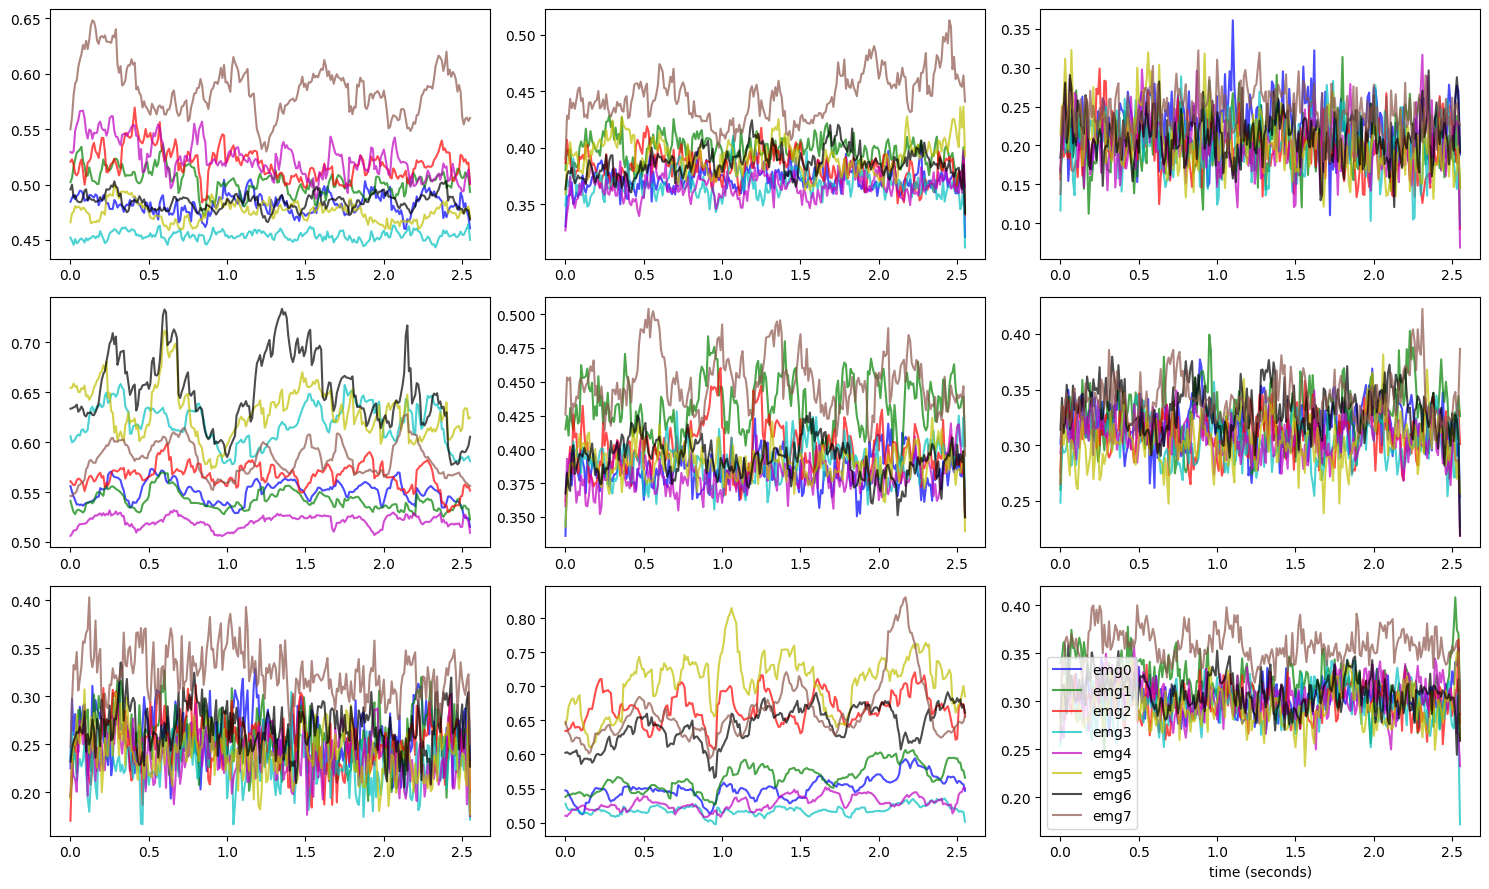

Epoch:  100
Epoch:  101
Epoch:  102
Epoch:  103
Epoch:  104
Epoch:105, loss: 0.018315567052923143
Epoch:  105
Epoch:  106
Epoch:  107
Epoch:  108
Epoch:  109
Epoch:110, loss: 0.018832455086521805
Epoch:  110
Epoch:  111
Epoch:  112
Epoch:  113
Epoch:  114
Epoch:115, loss: 0.01840853652295967
Epoch:  115
Epoch:  116
Epoch:  117
Epoch:  118
Epoch:  119
Epoch:120, loss: 0.017390582136188944
Epoch:  120
Epoch:  121
Epoch:  122
Epoch:  123
Epoch:  124
Epoch:125, loss: 0.01859973104825864
Epoch:  125
Epoch:  126
Epoch:  127
Epoch:  128
Epoch:  129
Epoch:130, loss: 0.016955963949051998
Epoch:  130
Epoch:  131
Epoch:  132
Epoch:  133
Epoch:  134
Epoch:135, loss: 0.0166878282946224
Epoch:  135
Epoch:  136
Epoch:  137
Epoch:  138
Epoch:  139
Epoch:140, loss: 0.016959135187789798
Epoch:  140
Epoch:  141
Epoch:  142
Epoch:  143
Epoch:  144
Epoch:145, loss: 0.017510681808926166
Epoch:  145
Epoch:  146
Epoch:  147
Epoch:  148
Epoch:  149
Epoch:150, loss: 0.017443654771583775
Saving...


  0%|          | 0/500 [00:00<?, ?it/s]

shape:  (9, 8, 256)
mean:  [[0.7936923  0.7799638  0.7911542  ... 0.80490875 0.8064813  0.80610996]
 [0.66809404 0.67080534 0.67041296 ... 0.6613674  0.66647094 0.67095965]
 [0.40323767 0.41039836 0.41312343 ... 0.40063208 0.40097052 0.3745411 ]
 ...
 [0.38540056 0.3947387  0.39346534 ... 0.38343278 0.39930293 0.3652661 ]
 [0.84666985 0.8458252  0.84425765 ... 0.8557115  0.85898316 0.868172  ]
 [0.5562984  0.56163615 0.55917126 ... 0.55129135 0.5508482  0.548047  ]]
std:  [[0.09653064 0.09182341 0.10402233 ... 0.09097171 0.09301966 0.0971348 ]
 [0.06693463 0.07226918 0.07119986 ... 0.06298028 0.06324726 0.06604234]
 [0.02656728 0.02195014 0.01583575 ... 0.02811536 0.02142959 0.01868807]
 ...
 [0.01695801 0.01728612 0.01910955 ... 0.02267596 0.02205654 0.02335892]
 [0.07620969 0.07673793 0.07661957 ... 0.06831311 0.07164481 0.07513263]
 [0.0170279  0.02193536 0.02223773 ... 0.01869287 0.01874438 0.01904053]]


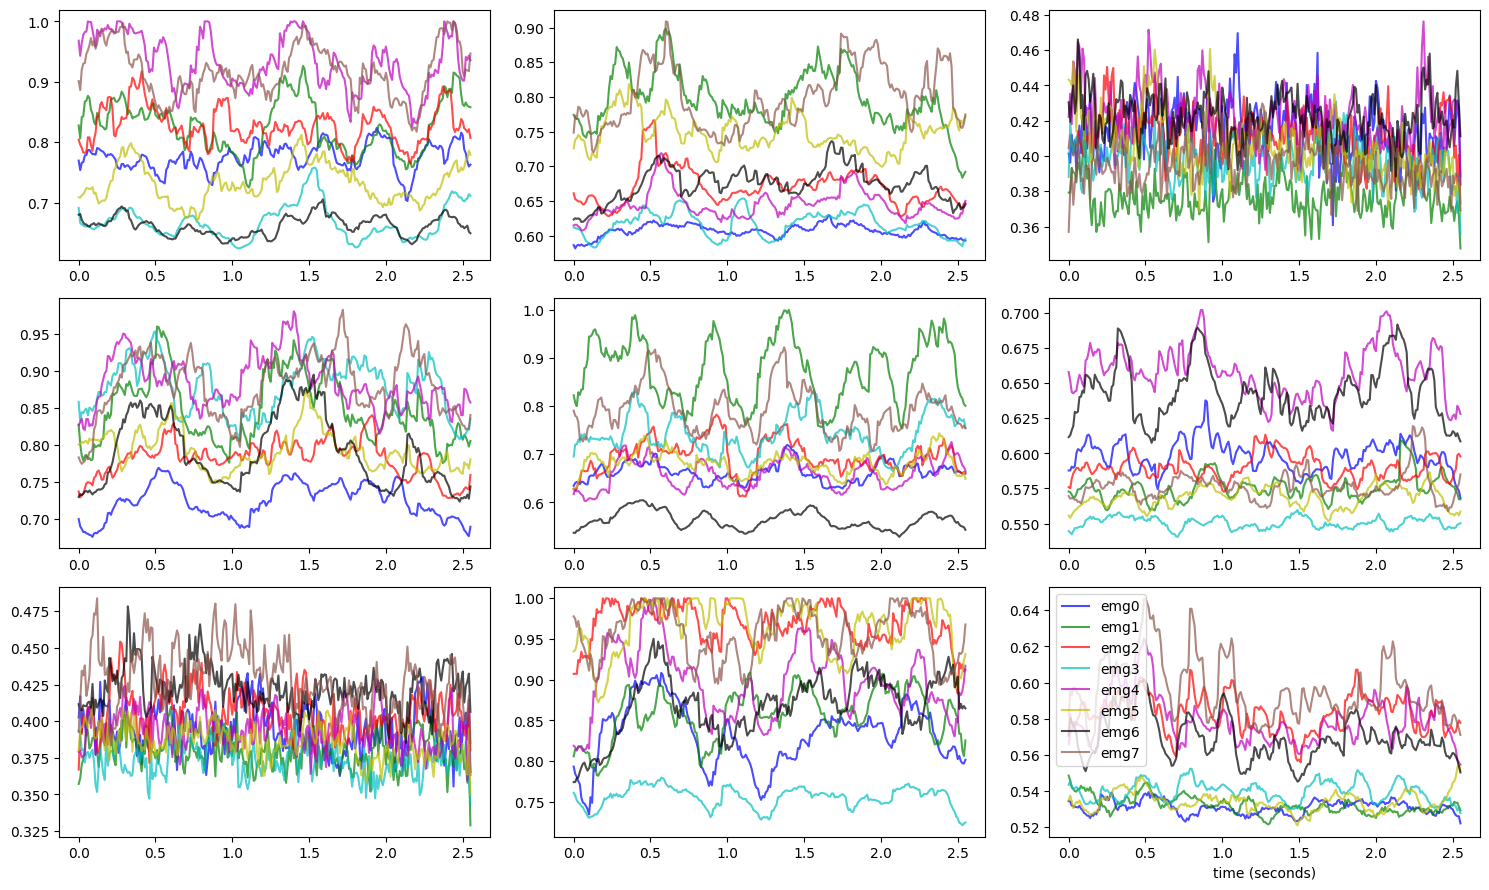

Epoch:  150
Epoch:  151
Epoch:  152
Epoch:  153
Epoch:  154
Epoch:155, loss: 0.017551048014623424
Epoch:  155
Epoch:  156
Epoch:  157
Epoch:  158
Epoch:  159
Epoch:160, loss: 0.018497785087674856
Epoch:  160
Epoch:  161
Epoch:  162
Epoch:  163
Epoch:  164
Epoch:165, loss: 0.017132128356024623
Epoch:  165
Epoch:  166
Epoch:  167
Epoch:  168
Epoch:  169
Epoch:170, loss: 0.016311850515194237
Epoch:  170
Epoch:  171
Epoch:  172
Epoch:  173
Epoch:  174
Epoch:175, loss: 0.017546099750325082
Epoch:  175
Epoch:  176
Epoch:  177
Epoch:  178
Epoch:  179
Epoch:180, loss: 0.015448023766900102
Epoch:  180
Epoch:  181
Epoch:  182
Epoch:  183
Epoch:  184
Epoch:185, loss: 0.01604334865696728
Epoch:  185
Epoch:  186
Epoch:  187
Epoch:  188
Epoch:  189
Epoch:190, loss: 0.015586520095045369
Epoch:  190
Epoch:  191
Epoch:  192
Epoch:  193
Epoch:  194
Epoch:195, loss: 0.016083570717213055
Epoch:  195
Epoch:  196
Epoch:  197
Epoch:  198
Epoch:  199
Epoch:200, loss: 0.017048991184371212
Saving...


  0%|          | 0/500 [00:00<?, ?it/s]

shape:  (9, 8, 256)
mean:  [[0.67423177 0.66728437 0.6755544  ... 0.7113508  0.70787746 0.70089996]
 [0.61677706 0.61783254 0.6166726  ... 0.6111403  0.60979927 0.60814947]
 [0.5011363  0.5105219  0.5163439  ... 0.486418   0.48373368 0.47247732]
 ...
 [0.4929258  0.50042796 0.5003583  ... 0.53263587 0.53353393 0.5278559 ]
 [0.7418807  0.74155915 0.74179846 ... 0.8115959  0.8110168  0.80487263]
 [0.5601489  0.5677367  0.5663006  ... 0.54853326 0.54728603 0.5443084 ]]
std:  [[0.07906423 0.0741708  0.08102173 ... 0.08433779 0.08232095 0.07765673]
 [0.05274371 0.05436612 0.05216279 ... 0.04409748 0.04463059 0.04456894]
 [0.03046443 0.03401937 0.032712   ... 0.02085271 0.01953938 0.02011732]
 ...
 [0.0152816  0.01731817 0.01743347 ... 0.03246564 0.03344678 0.03118596]
 [0.09059408 0.08915973 0.08820668 ... 0.07691096 0.07489504 0.07434939]
 [0.02116977 0.02721052 0.02643866 ... 0.01981605 0.01995984 0.01929783]]


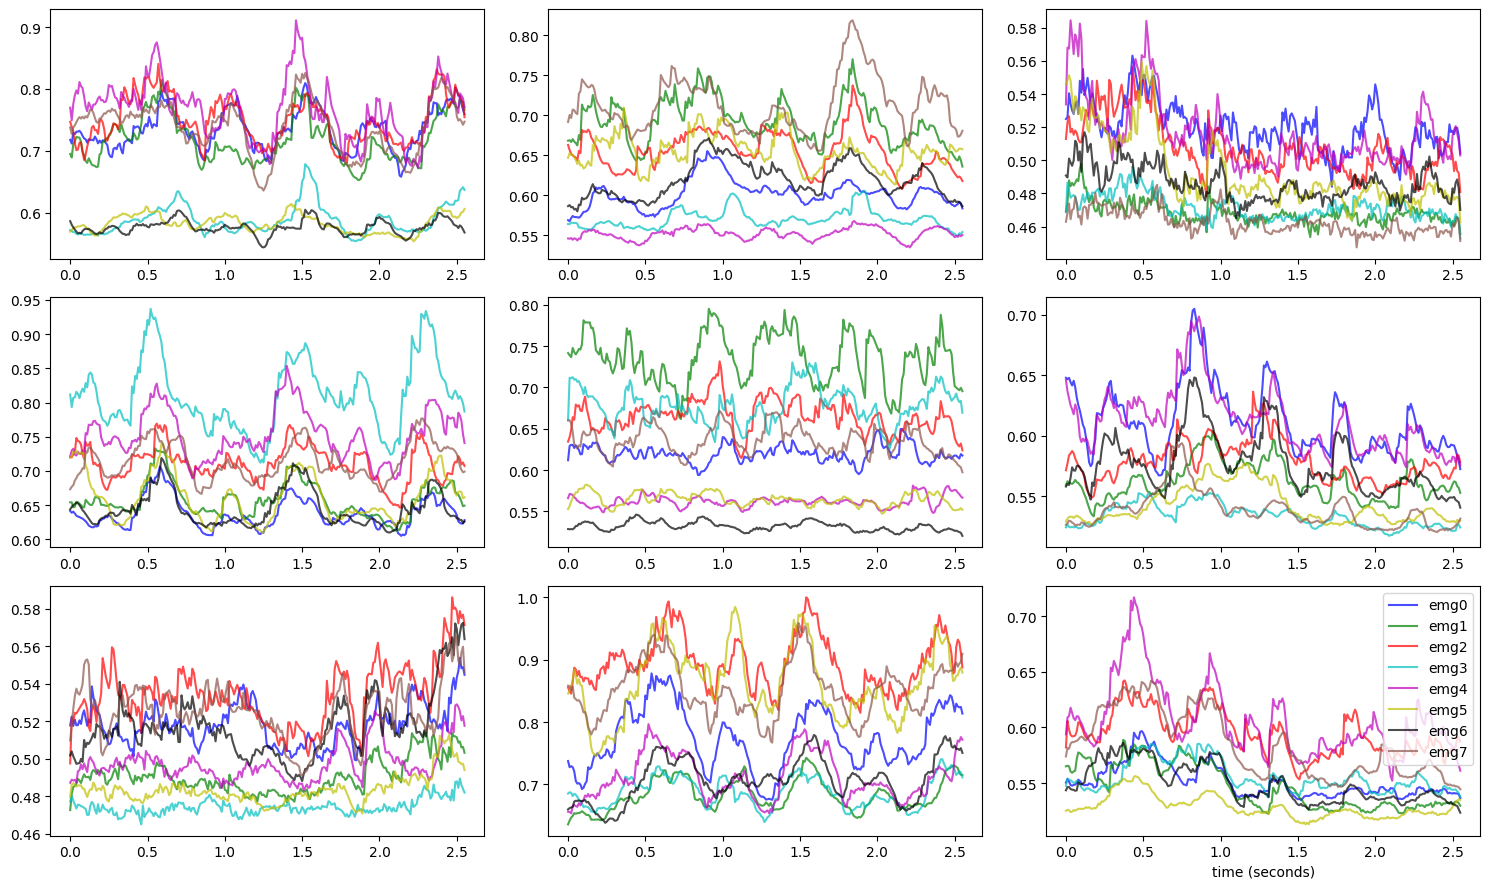

In [ ]:
import torch.nn.functional as F

if config.train:
  # Set the noise scheduler
  noise_scheduler = DDPMScheduler(
      num_train_timesteps=config.noise_scheduler_timesteps, beta_schedule="squaredcos_cap_v2"
  )

  # Training loop
  optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

  losses = []

  print("Total epochs: ",  config.num_epochs)
  for epoch in range(config.num_epochs):
      print("Epoch: ", epoch)
      for step, batch in enumerate(train_dataloader):
        batch_x, batch_y = get_batch('train')
        batch = diffuser_batch_preprocess(batch_x, is2d=True)
        clean_seqs = batch.to(device)
          #print("batch shape: ", batch.shape)

          # Sample noise to add to the images
        noise = torch.randn(clean_seqs.shape).to(device)

        bs = clean_seqs.shape[0] #batch size

          # Sample a random timestep for each image
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=device).long()

          # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_seqs = noise_scheduler.add_noise(clean_seqs, noise, timesteps)

          # Get the model prediction
        noise_pred = model(noisy_seqs, timesteps, return_dict=False)[0]

          # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

          # Update the model parameters with the optimizer
          # why UNet side no gradient
        optimizer.step()
        optimizer.zero_grad()

      if (epoch + 1) % 5 == 0:
          loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
          print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")
      # saving
      if (epoch + 1) % config.save_epochs == 0:
        print("Saving...")
        save_path = "./2DUnet-p8-train-ep"+str(epoch+1)
        model.save_pretrained(save_path)
        output = deterministic_generate_sequences(model)

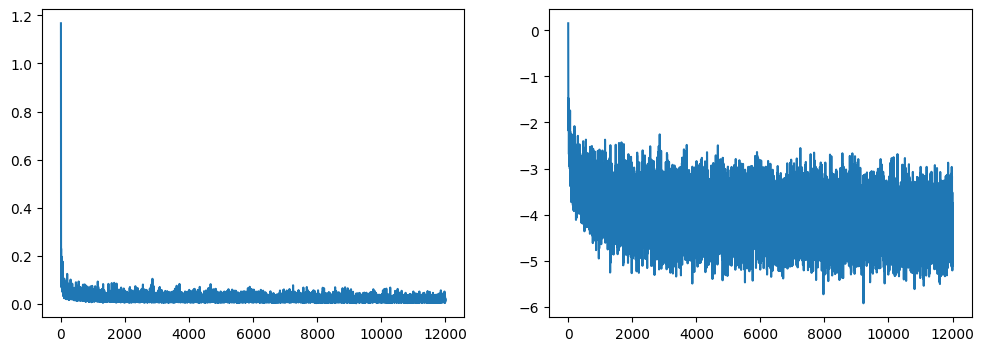

In [ ]:
if config.train:
  fig, axs = plt.subplots(1, 2, figsize=(12, 4))
  axs[0].plot(losses)
  axs[1].plot(np.log(losses))
  plt.show()

# Save model

In [ ]:
if config.save_model:
  model.save_pretrained(config.save_model_path)

In [ ]:
model.save_pretrained("./2DUnet-p8-111-ep400")

# Generate Sequence

In [ ]:
from diffusers import DDPMPipeline

emgseq_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)

In [ ]:
def generate_sequences():
  pipeline_output = emgseq_pipe(batch_size=config.gen_batch_size,num_inference_steps=config.noise_scheduler_timesteps,output_type=np.array)
  gen_seqs = pipeline_output.images
  gen_seqs = gen_seqs.squeeze()
  print("shape: ", gen_seqs.shape)
  gen_seqs = np.transpose(gen_seqs, axes=(0,2,1))
  print("mean: ", np.mean(gen_seqs, axis=2))
  print("std: ", np.std(gen_seqs, axis=2))
  plot_emg_chunks(gen_seqs, nrows=config.nrows, ncols=config.ncols)
  return pipeline_output.images

  0%|          | 0/500 [00:00<?, ?it/s]

shape:  (9, 8, 256)
mean:  [[0.6763176  0.67324257 0.67016476 ... 0.6273424  0.62749577 0.62893164]
 [0.6396041  0.638948   0.6354588  ... 0.6064169  0.6073712  0.6079168 ]
 [0.6679412  0.67319953 0.67353326 ... 0.6342147  0.623968   0.6250331 ]
 ...
 [0.6394036  0.6379395  0.6332084  ... 0.56475425 0.565721   0.56619424]
 [0.63098186 0.6305569  0.63123107 ... 0.5934295  0.5930401  0.5942057 ]
 [0.56477684 0.5719863  0.57285696 ... 0.582323   0.5831591  0.5843402 ]]
std:  [[0.08897879 0.08809681 0.08815254 ... 0.06239911 0.06276034 0.06367776]
 [0.05240311 0.05279167 0.04629587 ... 0.04221547 0.04256055 0.04004933]
 [0.08034328 0.08512721 0.08573319 ... 0.06496038 0.05515642 0.05588777]
 ...
 [0.06568404 0.06344769 0.05853683 ... 0.03321046 0.03161703 0.0318012 ]
 [0.05122678 0.05348628 0.05519963 ... 0.02990366 0.02958577 0.02929163]
 [0.03054887 0.03569376 0.03610227 ... 0.03919668 0.03922633 0.03933536]]


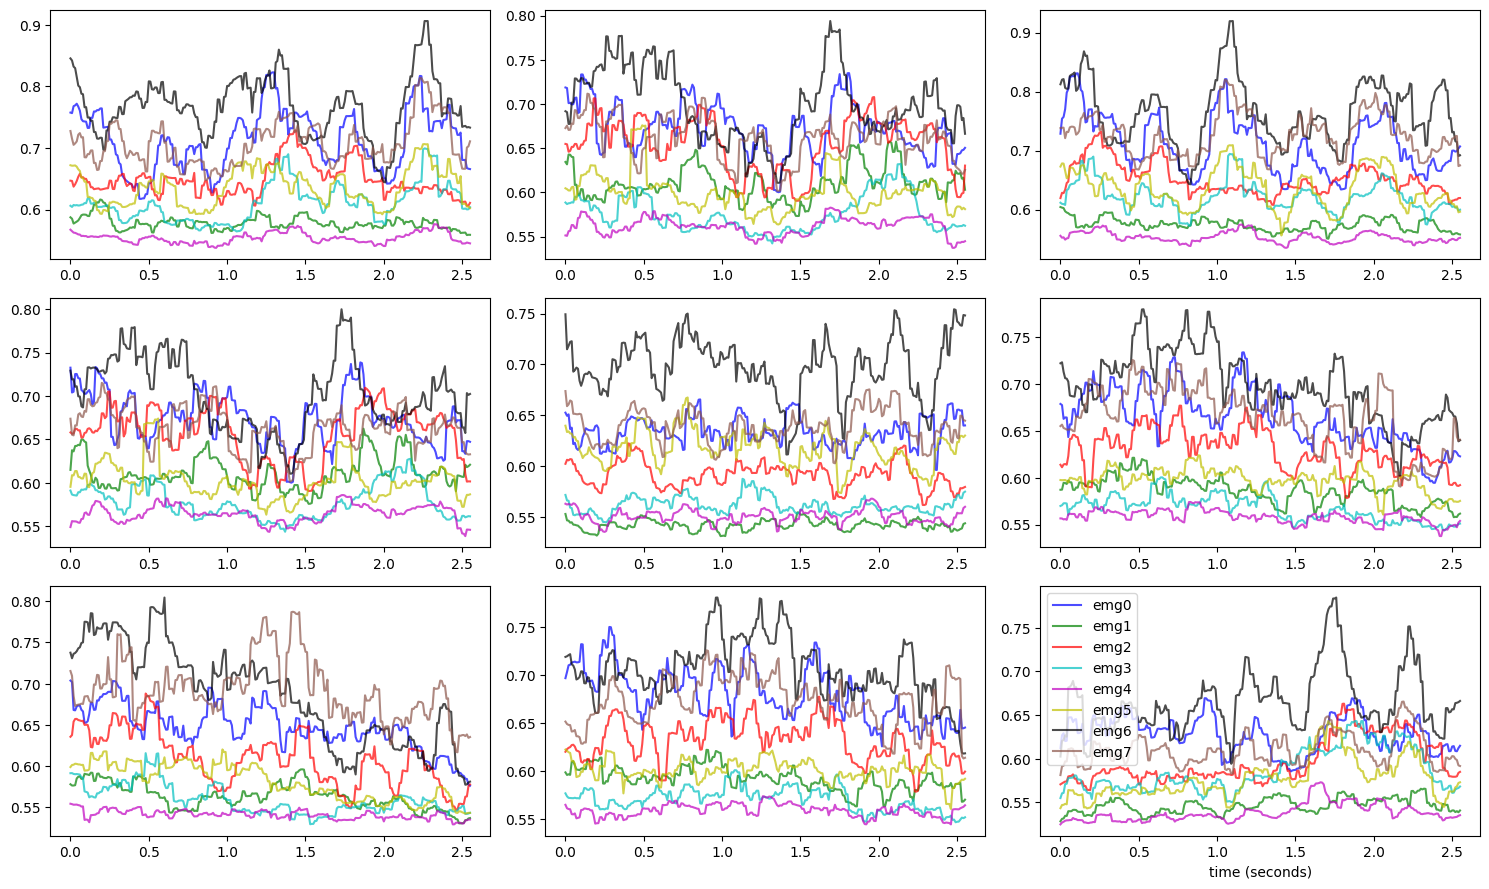

In [ ]:
output = generate_sequences()

In [ ]:
from diffusers import DDPMPipeline

def deterministic_generate_sequences(this_model):
  deterministic_generator = torch.Generator()
  deterministic_generator.manual_seed(42)
  emgseq_pipe = DDPMPipeline(unet=this_model, scheduler=noise_scheduler)
  pipeline_output = emgseq_pipe(batch_size=config.gen_batch_size,num_inference_steps=config.noise_scheduler_timesteps,output_type=np.array,generator=deterministic_generator)
  gen_seqs = pipeline_output.images
  gen_seqs = gen_seqs.squeeze()
  print("shape: ", gen_seqs.shape)
  gen_seqs = np.transpose(gen_seqs, axes=(0,2,1))
  print("mean: ", np.mean(gen_seqs, axis=2))
  print("std: ", np.std(gen_seqs, axis=2))
  plot_emg_chunks(gen_seqs, nrows=config.nrows, ncols=config.ncols)
  return pipeline_output.images

  0%|          | 0/500 [00:00<?, ?it/s]

shape:  (9, 8, 256)
mean:  [[0.67423177 0.66728437 0.6755544  ... 0.71135086 0.7078775  0.70089996]
 [0.61677694 0.6178324  0.6166725  ... 0.6111403  0.60979927 0.60814947]
 [0.50113636 0.5105219  0.5163439  ... 0.48641804 0.48373368 0.47247732]
 ...
 [0.49292582 0.50042796 0.5003583  ... 0.53263587 0.533534   0.5278559 ]
 [0.7418807  0.74155915 0.74179846 ... 0.8115959  0.8110168  0.80487263]
 [0.5601489  0.5677367  0.5663006  ... 0.5485332  0.54728603 0.5443084 ]]
std:  [[0.07906421 0.07417079 0.08102172 ... 0.08433779 0.08232096 0.07765674]
 [0.05274364 0.05436609 0.05216276 ... 0.04409748 0.0446306  0.04456895]
 [0.03046442 0.03401938 0.032712   ... 0.0208527  0.01953937 0.02011732]
 ...
 [0.0152816  0.01731817 0.01743347 ... 0.03246564 0.03344677 0.03118596]
 [0.09059409 0.08915973 0.08820668 ... 0.07691096 0.07489504 0.07434938]
 [0.02116977 0.02721052 0.02643865 ... 0.01981606 0.01995985 0.01929783]]


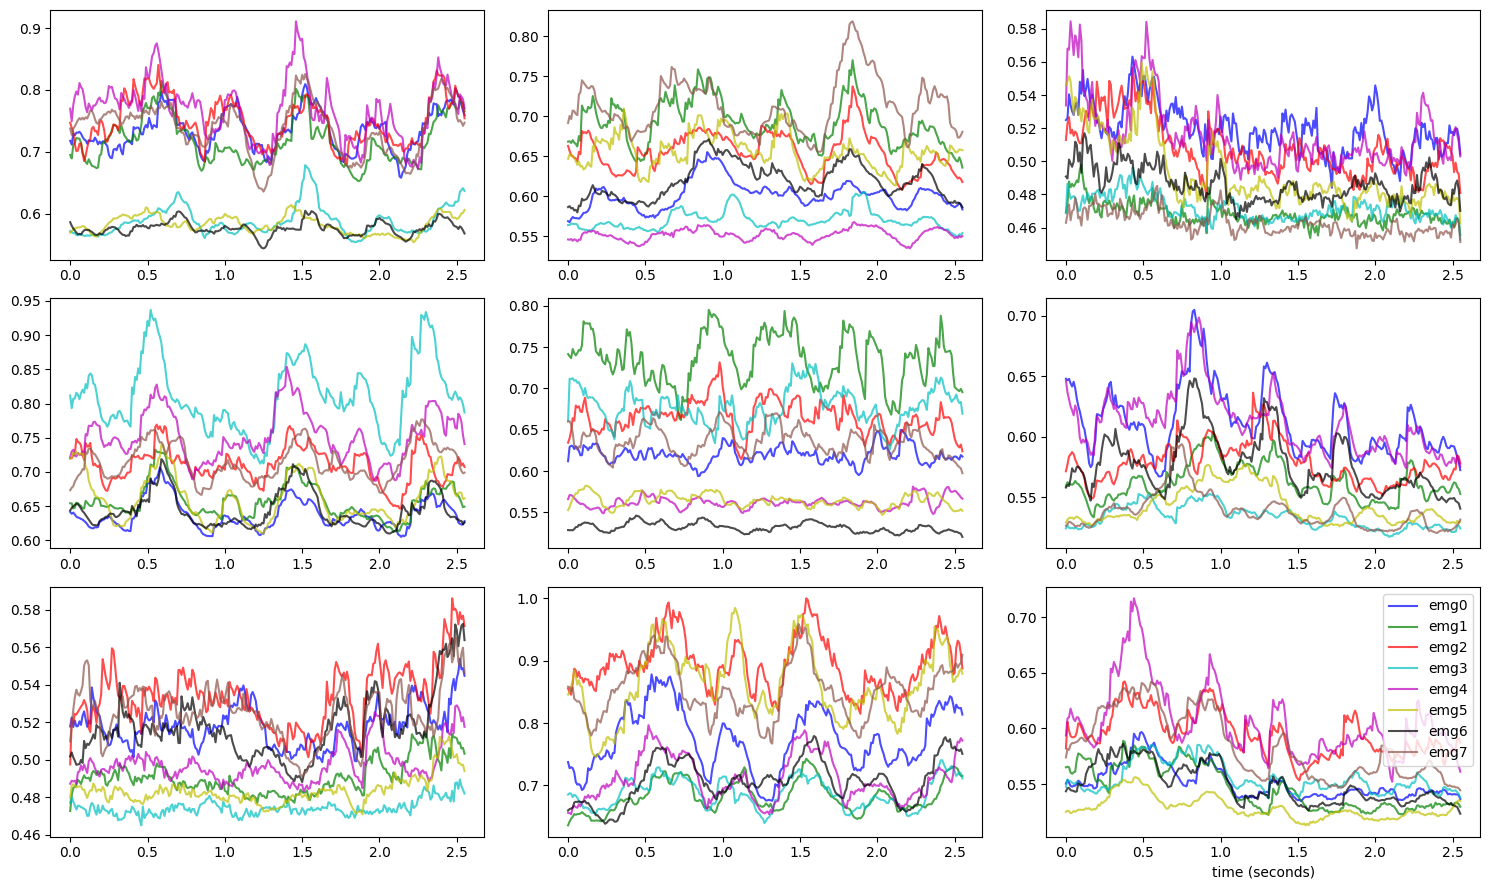

In [ ]:
output = deterministic_generate_sequences(model)


test

In [ ]:
!unzip 2Dunet-p8-train-ep200.zip

Archive:  2Dunet-ep400.zip
   creating: 2Dunet-ep400/
  inflating: 2Dunet-ep400/config.json  
  inflating: 2Dunet-ep400/diffusion_pytorch_model.bin  


In [ ]:
p1_model = UNet2DModel.from_pretrained("/content/2DUnet-p8-train-ep200").to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


  0%|          | 0/500 [00:00<?, ?it/s]

shape:  (9, 8, 256)
mean:  [[0.5732495  0.5745144  0.57502294 ... 0.5864965  0.5890462  0.5889944 ]
 [0.53303844 0.53386164 0.534099   ... 0.5635896  0.5668862  0.56709385]
 [0.53443    0.5349507  0.5344846  ... 0.53184664 0.5312846  0.5309935 ]
 ...
 [0.60675615 0.60767967 0.608084   ... 0.6409097  0.6451159  0.64555633]
 [0.6910577  0.6924399  0.6960079  ... 0.64461464 0.650501   0.6494263 ]
 [0.62664086 0.6290039  0.6277849  ... 0.59941375 0.59926164 0.5993443 ]]
std:  [[0.05052587 0.05476322 0.05428117 ... 0.06142312 0.06435083 0.06471084]
 [0.02245596 0.02315859 0.0234615  ... 0.04386757 0.04641866 0.04676318]
 [0.02905669 0.02994994 0.0292516  ... 0.02510468 0.02400088 0.02431732]
 ...
 [0.08135634 0.08125985 0.08138844 ... 0.1333388  0.13259421 0.13402608]
 [0.08592744 0.0869834  0.08267803 ... 0.07551225 0.08058758 0.08063763]
 [0.06501331 0.06682643 0.06654341 ... 0.04482061 0.049878   0.04993476]]


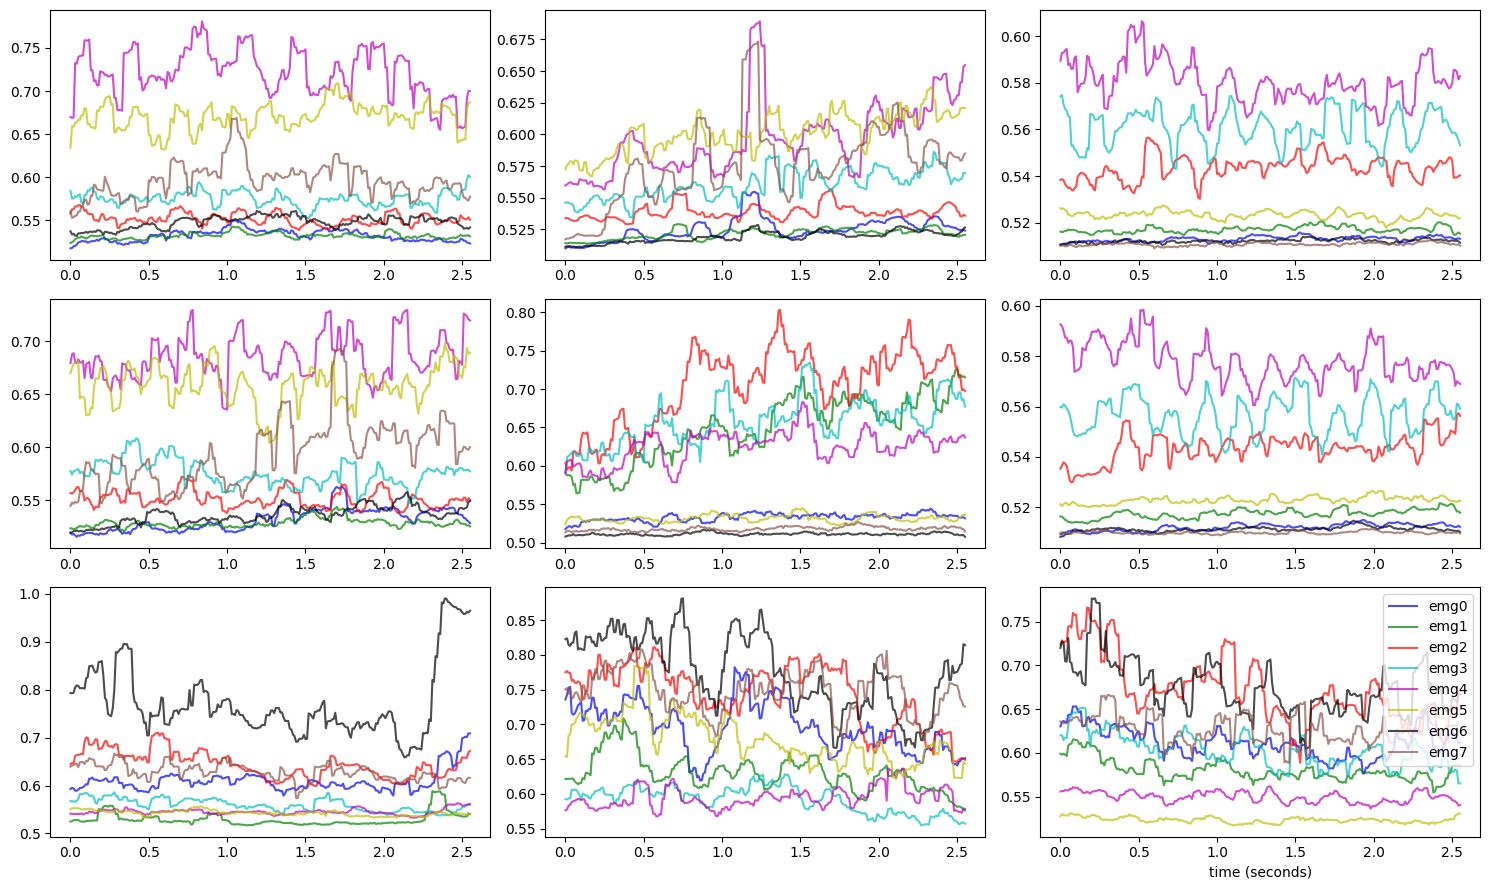

In [ ]:
output = deterministic_generate_sequences(p1_model)


In [ ]:
!unzip 2Dunet-ep200.zip

Archive:  2Dunet-ep200.zip
   creating: 2Dunet-ep200/
  inflating: 2Dunet-ep200/config.json  
  inflating: 2Dunet-ep200/diffusion_pytorch_model.bin  


In [ ]:
p1_200_model = UNet2DModel.from_pretrained("/content/2Dunet-ep200").to(device)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [ ]:
output = deterministic_generate_sequences(p1_200_model)


NameError: ignored